<h1 style="text-align: center"> Assignment #4 </h1>


<h4 style="text-align: center"> Kevin McManus </h4>
<h4 style="text-align: center"> Student ID: 109702479</h4>

In [1]:
import numpy as np
import pandas as pd

## 0. MyData Class

Copied from last week's homework notebook McManus3.ipynb.
Additional class methods, per the instructions of the assignment are in the sections that follow.

In [2]:
#From Chapter 3
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.interpolate import UnivariateSpline
import scipy.ndimage
from scipy import signal
from astropy.io import fits

class MyData:
    def __init__(self,filename='NoFile'):
        self.filename = filename
        self.ndim = 0 
        self.x = []
        self.nx = 0
        self.y = []
        self.ny = 0
        self.z = []
        self.nz = 0
        self.array = []
        self.header = []
        self.nxa = 0
        self.nya = 0
        
    def xline(self,xmin,xmax,nx):
        self.nx = nx
        self.ndim = 1
        self.x = np.linspace(xmin,xmax,nx)

    def yline(self,a,b):
        if(self.ndim == 1):
            self.ny = self.nx
            self.y = a + b*self.x
        else:
            print("x value not one dimensional")

    def plotxy(self):
        plt.cla()
        plt.title(self.filename)
        plt.plot(self.x,self.y)
        plt.show()

    def plotpoints(self):
        plt.cla()
        plt.title(self.filename)
        #plt.plot(self.x,self.y)
        plt.scatter(self.x, self.y, s=2, marker='o', c='black')
        plt.show()

    def GetFits(self, filename):
        self.filename = filename
        hdul = fits.open(filename)
        self.array = fits.getdata(filename)
        self.header = hdul[0].header
        sh = np.shape(self.array)
        self.nxa = sh[0]
        self.nya = sh[1]
        self.ndim = 2
            
    def GetTableData(self, filename):
        self.filename = filename
        data_array=np.genfromtxt(filename)
        s = data_array.shape
        if len(s) == 1 :
            self.x= data_array
            self.nx = s[0]
        if len(s) == 2 :
            self.x = data_array[:, 0]
            self.y = data_array[:, 1]
            self.nx = s[0]
            self.ny = s[0] #one y value for each x value

    def WriteTableData(self,filename='test.txt'):
        f = open(filename,"w")
        if self.ny == 0:
            for i in range(0,self.nx):
                f.write('%8.4f\n' % self.x[i] )
        else:
            for i in range(0,self.nx):
                f.write('%8.4f  %8.4f\n' % (self.x[i],self.y[i]))
        f.close()

    def Quicklook(self):
        if (self.nx == 0):
            print("Whoops! No Data")
            return
        plt.cla()
        if self.ny == 0:
            plt.plot(self.x, c='black')
        else:
            plt.scatter(self.x, self.y, s=2, marker='o', c='black')
        plt.show()
        print("length of x list is ",len(self.x), "items")
        
    def ReadInteger16(self,filename,nxa=256,nya=256):
        self.filename = filename
        data = np.fromfile('m33.dat', dtype='i2')
        self.array = np.reshape(np.array(data),(nxa,nya))
        self.ndim = 2
        self.nxa = nxa
        self.nya = nya
        
    def WriteFloat64(self,filename="test.dat"):
        self.filename = filename
        f= open(self.filename,"w+")
        self.x.tofile(f)
        f.close()

    def ReadFloat64(self,filename="test.dat",nxa=256,nya=256):
        self.filename = filename
        f= open(self.filename,"r")
        self.y=np.fromfile(f,'f8')
        f.close()

    def ReadExcelColumn(self, filename, sheetname, columnname):
        self.filename = filename
        e = pd.ExcelFile(filename)
        ep = e.parse(sheetname)
        df=ep[columnname]
        self.x = df.values
        self.nx = len(self.x)
        self.ndim = 1
        
    def WriteExcelColumn(self, filename):
        df = pd.DataFrame(data=self.x)
        with pd.ExcelWriter(filename) as writer:
            df.to_excel(writer)
            
    def MyHistogram(self,bins=10):
        hi=np.histogram(self.x,bins=bins)
        hy=np.array(hi[0])
        hx=np.array(hi[1])
        hx=hx[1:]
        plt.cla()
        #plt.plot(hx,hy,linestyle='steps')
        plt.plot(hx,hy,linestyle='-')
        plt.show()

    def Slice(self, slc):
        """
        slices self.x and self.y according to slc
        """
        if self.nx == 0:
            raise ValueError('Data object has no data to slice')
        self.x = self.x[slc]
        self.nx = len(self.x)
        if self.ny != 0:
            self.y = self.y[slc]
            self.ny = len(self.y)

## 1. M33 Image
> The file M33.dat contains one million 16 bit integers. The integers represent the intensities in a 1000x1000 image of that nearby galaxy. Each pixel has only an intensity, and not a color, effectively making it a black and white image.
Read in M33.dat using ReadInteger16 as in Chapter3A.ipynb. Put the image plotting code lines
into a new routine in MyData called MyImage(). Run and make certain it still works.
Since this file was originally a black and white image, change MyImage so that it has a calling
parameter called cmap and set the default to ‘gray’. A black and white image is actually a gray
scale image, so the colormap called ‘gray’ should yield a nice black and white version of the
M33 image. Find some other colormaps online and try those, until you find a false color image
that you like.
Add a calling parameter cb whose default is False. If cb is set to True, then have MyImage
provide a colorbar to the side of the image.
Add a smoothing parameter, and smooth out the image using a function from scipy.
And, finally, add a parameter that turns contours on and off in the image. 

#### `MyImage` Class Method

In [3]:
from scipy.ndimage import convolve, gaussian_filter

#helper routine for smoothing
def smoother(self, smooth_type='gaussian', smooth_param=1.0):

    if smooth_type != 'gaussian' and smooth_type != 'convolve':
        raise ValueError(f'Invalid smooth_type: {smooth_type}, valid smooth_types: gaussian and convolve')
    
    #prevent overflows
    if self.array.dtype == np.int16:
        data = self.array.astype(np.int32)
    else:
        data = self.array

    if smooth_type == 'gaussian':
        smoothed = gaussian_filter(data, smooth_param)
    elif smooth_type == 'convolve':
        filter = np.ones((smooth_param, smooth_param))
        smoothed = convolve(data, filter)/filter.sum() # retain orig scaling
    else:
        assert False # shouldn't get here

    return smoothed
        

def MyImage(self,**kwargs):
    ax = kwargs.pop('ax', None)
    cmap = kwargs.pop('cmap', 'gray')
    title = kwargs.pop('title', self.filename)
    cb = kwargs.pop('cb', False)
    contours = kwargs.pop('contours', False)
    smooth_type = kwargs.pop('smooth_type', None)
    smooth_param = kwargs.pop('smooth_param', None)
    contours = kwargs.pop('contour_lines', False)
    levels = kwargs.pop('levels', None)

    fig = None
    if ax is None:
        fig, ax = plt.subplots()

    if smooth_type is None:
        data = self.array
    else:
        data = self.smoother(smooth_type, smooth_param)
    
    pcb = ax.imshow(data, origin='lower',  cmap=cmap)

    if contours:
        pcb = ax.contour(data, origin='lower', levels=levels, cmap='Reds')


    ax.set_title(title)

    #put the colorbar on if requested
    if cb:
        cbar = plt.colorbar(pcb, ax=ax, shrink=0.65, pad=0.05)
        cbar.set_label('Intensity', rotation=270)

    #since this is an image, ditch the axes ticks and labels
    ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)

    return pcb

MyData.smoother = smoother
MyData.MyImage = MyImage
    

### `MyImage` Usage

#### Read Data and Display Default Image

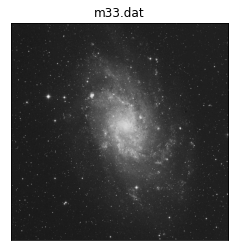

In [4]:
m33 = MyData()
m33.ReadInteger16('m33.dat', nxa=1000, nya=1000)
m33.MyImage()



#### Image With and Without Colorbar

The `cb` parameter controls whether the displayed image contains a color bar.

Text(0.5, 0.98, 'Color Bar Functionality')

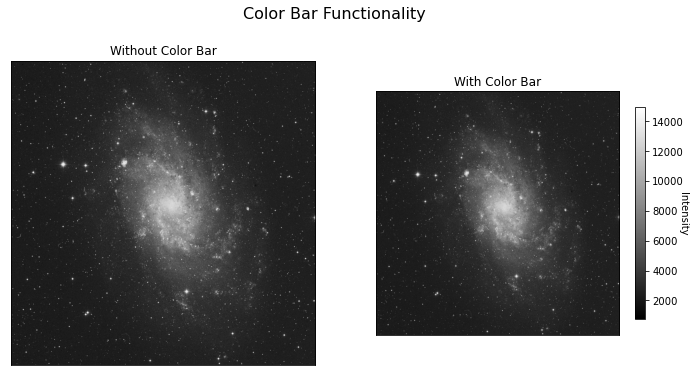

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
for ax, cb in zip(axs,[False, True]):

    m33.MyImage(ax = ax,  cb=cb, title='With Color Bar' if cb else 'Without Color Bar')
fig.suptitle('Color Bar Functionality',size=16)

#### Color Map Variations

Specify the color map with the `cmap` parameter.

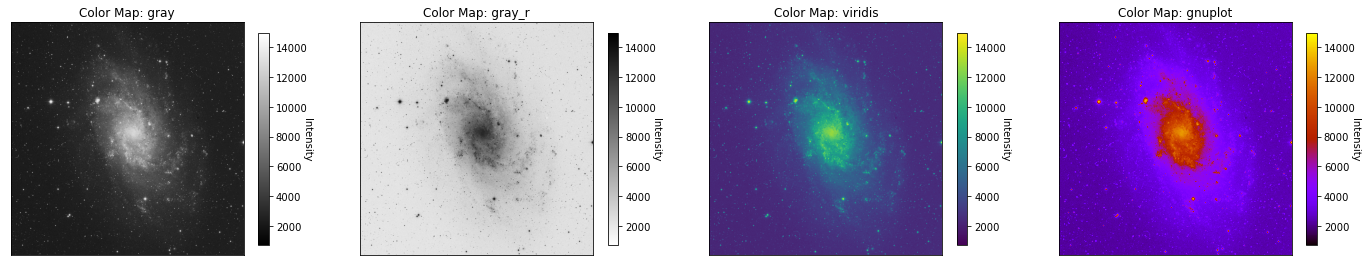

In [6]:
cmaps = ['gray', 'gray_r','viridis', 'gnuplot']
n = len(cmaps)
fig, axs = plt.subplots(ncols=n, figsize=(n*6,6))
for ax, cmap in zip(axs, cmaps):

    m33.MyImage(ax = ax, cmap=cmap, cb=True, title=f'Color Map: {cmap}')

#### With Smoothing

Two smoothing methods are implemeneted: `gaussian` and `convolve` Each method takes a parameter. The plots below compare the two different methods and their parameters against the original image.

Text(0.5, 0.98, 'Gaussian Smoothing')

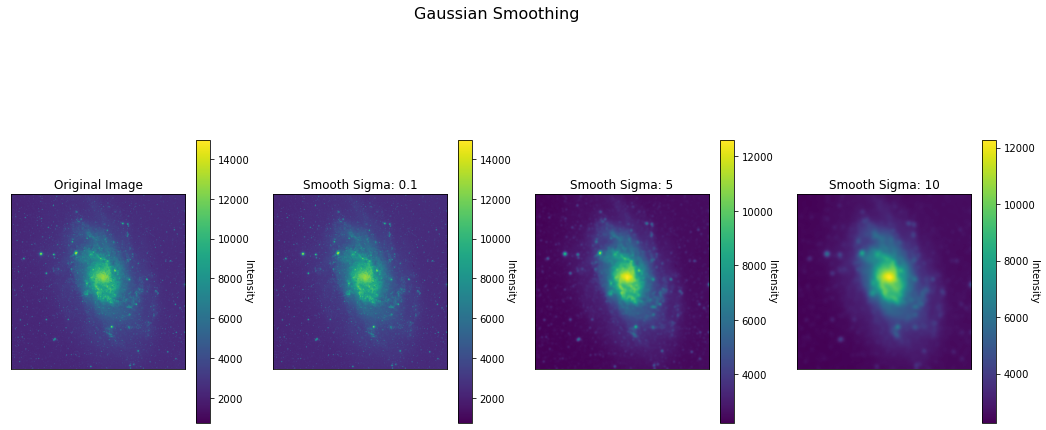

In [7]:
smooth_lambdas = [0.1, 5, 10]
n = len(smooth_lambdas)
fig, axs = plt.subplots(ncols=n+1, figsize=(n*6,8))

m33.MyImage(ax = axs[0], cmap='viridis', cb=True, smooth_type = None, title='Original Image')
for ax, smooth_lambda in zip(axs[1:], smooth_lambdas):

    m33.MyImage(ax = ax, cmap='viridis', cb=True, smooth_type='gaussian', smooth_param = smooth_lambda, title=f'Smooth Sigma: {smooth_lambda}')

fig.suptitle('Gaussian Smoothing',size=16)

Text(0.5, 0.98, 'Convolutional Smoothing')

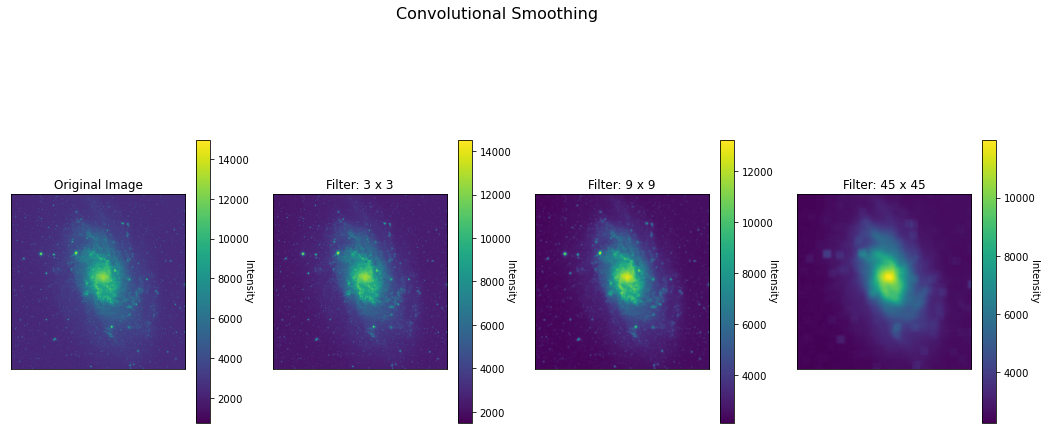

In [8]:
#Convolutional Smoothing
filter_sizes = [3, 9, 45]
n = len(smooth_lambdas)
fig, axs = plt.subplots(ncols=n+1, figsize=(n*6,8))

m33.MyImage(ax = axs[0], cmap='viridis', cb=True, smooth_type = None, title='Original Image')
for ax, f in zip(axs[1:], filter_sizes):

    m33.MyImage(ax = ax, cmap='viridis', cb=True, smooth_type='convolve', smooth_param = f, title=f'Filter: {f} x {f}')

fig.suptitle('Convolutional Smoothing',size=16)


#### Image with Contour Lines

The three images below progress from the original image to the smoothed one to the smoothed image with contour lines.

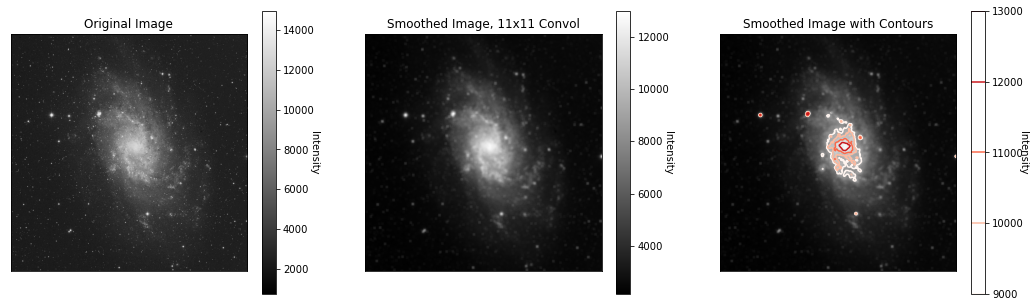

In [9]:
fig, axs = plt.subplots(ncols=3,figsize=(18,8))

m33.MyImage(ax=axs[0], contour_lines=False,  cb=True, title='Original Image')
m33.MyImage(ax=axs[1], contour_lines=False,  smooth_type='convolve', smooth_param=11, cb=True, title='Smoothed Image, 11x11 Convol')
m33.MyImage(ax=axs[2], contour_lines=True, levels=[9e3, 10e3, 11e3, 12e3, 13e3], smooth_type='convolve', smooth_param=11, cb=True, title='Smoothed Image with Contours')


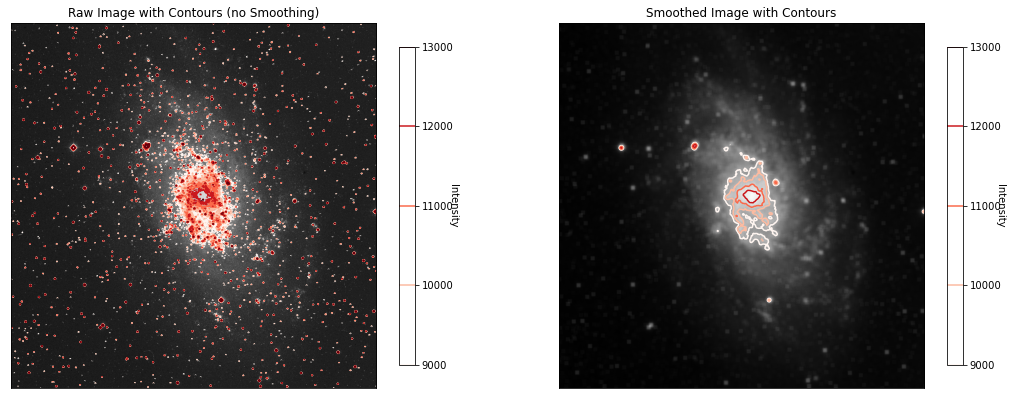

In [10]:
#larger sized image with the contours
fig, axs = plt.subplots(ncols=2,figsize=(18,9))
m33.MyImage(ax=axs[0], contour_lines=True, levels=[9e3, 10e3, 11e3, 12e3, 13e3], smooth_type=None, smooth_param=11, cb=True, title='Raw Image with Contours (no Smoothing)')
m33.MyImage(ax=axs[1], contour_lines=True, levels=[9e3, 10e3, 11e3, 12e3, 13e3], smooth_type='convolve', smooth_param=11, cb=True, title='Smoothed Image with Contours')


## 2. Spline Fitting

>Read the data from SplineExample.txt into a data instance called D. Use Quicklook() to take a
look at the data. Create a function called MySpline() that returns a spline function. Deepcopy D
into a new data instance called D2. In the new data instance set x to a linspace() with a hundred
points across much of the range of SplineExample. Set the D2.y values to spline(D2.x) Plot the
splined curve in D2 using a Data class function. 

#### Load and Examine the `SplineExample` data

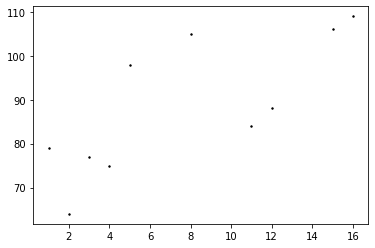

length of x list is  10 items


In [11]:

D = MyData()
D.GetTableData('SplineExample.txt')
D.Quicklook()

### Create `MySpline` Method

In [12]:
from scipy.interpolate import UnivariateSpline
def MySpline(self, **kwargs):
    #kwargs are other arguments passed along to UniSpline
    func = UnivariateSpline(self.x, self.y, **kwargs)
    return func

MyData.MySpline = MySpline

### Spline Fit over Range of `D.x`

In [13]:
from copy import deepcopy
func = D.MySpline()
xx = np.linspace(D.x.min(), D.x.max(), 100)
yy = func(xx)

D2 = deepcopy(D)
D2.x = xx; D2.nx = len(xx)
D2.y = yy; D2.ny = len(yy)



### Display Original and Spline Fitted Data

In [14]:
#slight adjustment to plotpoints so that it can plot multiple MyData instances on same axes
def plotpoints(self, **kwargs):

    title = kwargs.pop('title', self.filename)
    ax = kwargs.pop('ax', None)
    # the rest of the kwargs go to ax.scatter

    if ax is None:
        fig, ax = plt.subplots()
    
    #plt.plot(self.x,self.y)
    plt.scatter(self.x, self.y, **kwargs)
    ax.set_title(title)


MyData.plotpoints = plotpoints

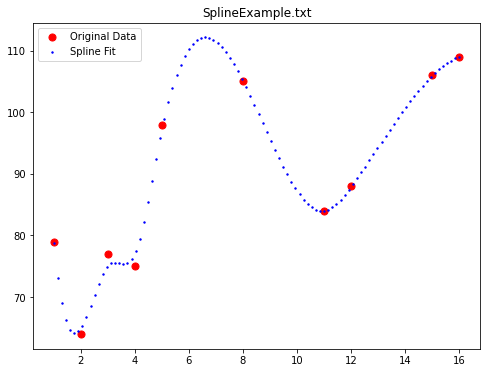

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
D.plotpoints(ax=ax, s=50, color='red', label='Original Data', marker='o')
D2.plotpoints(ax=ax, s=2, color='blue', label='Spline Fit')
ax.legend()

## 3. Histogram of rays.txt

>Read in the first two columns of rays.txt again. Create a new MyData class function called
MyHistogram() that creates and plots a histogram of the self.x values. The calling parameters to
MyHistogram() should be the number of bins across the range and the range from minimum to
maximum. Make the range large enough to show the zeroes at each end, and set the bin size to
nicely show the distribution. Hint: look up how to use histogram in the numpy online manual. 

rays.nx: 980, rays.ny: 980, len(rays.x): 980, len(d.y): 980


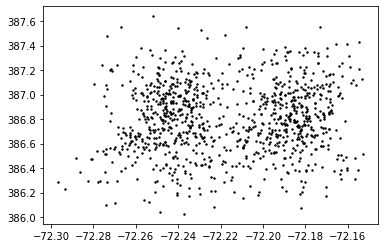

length of x list is  980 items


In [16]:
rays = MyData(filename='rays.txt')
#load up the rays.txt file
rays.GetTableData('rays.txt')
print(f'rays.nx: {rays.nx}, rays.ny: {rays.ny}, len(rays.x): {len(rays.x)}, len(d.y): {len(rays.y)}')

rays.Quicklook()

#### `MyHistogram` Class Method

In [17]:
def MyHistogram(self,**kwargs):
    ax = kwargs.pop('ax', None)
    xlim = kwargs.pop('xlim', (None, None))
    title = kwargs.pop('title', self.filename)
    density = kwargs.pop('density', False)
    grid = kwargs.pop('grid', True)
    which = kwargs.pop('which','x')

    data = getattr(self, which)


    fig = None
    if ax is None:
        fig, ax = plt.subplots()

    ax.hist(data, density=density, **kwargs)
    
    ylab = ('Density' if density else 'Count') + f' of {which}'
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.set_xlim(xlim)
    if grid:
        ax.grid(axis='y')


MyData.MyHistogram = MyHistogram

#### `MyHistogram()` Usage

The plot below shows the output of the `MyHistogram` method, using its default parameters:

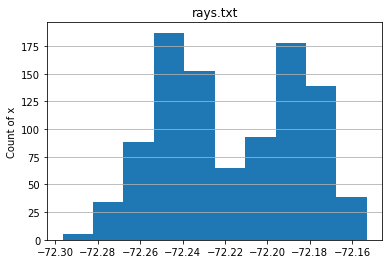

In [18]:
#MyHistogram with no arguments = default histogram
rays.MyHistogram()

Parameters can change the default behavior. The `bins` argument specifies the number of bins; `xlim` (a tuple) specifies the range on the x-axis of the histogram; `density` (boolean) determines whether the histogram integrates to 1 or the total number of observations. All other arguments are passed to `matplotlib.pyplot.ax.hist` as the `color` and `alpha` arguments below exemplify.

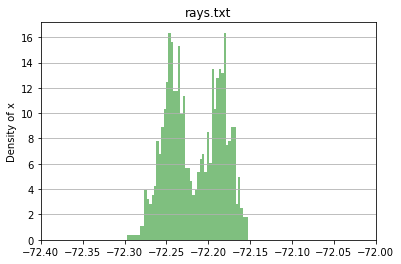

In [19]:
#bins, color, and alpha parameters are actually handled by ax.hist()
rays.MyHistogram(bins=50, density=True, xlim=(-72.4,-72), color='green', alpha=0.5)

The `which` parameter controls which of the `x`, `y`, or `z` members of `MyData` is plotted. To see a histogram of the `y` variable for example, pass `which = 'y'` as below.

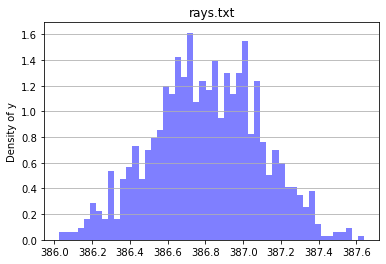

In [20]:
rays.MyHistogram(which='y',bins=50, density=True, color='blue', alpha=0.5)

Specifying the `ax` parameter allows placing multiple histograms on the same axis, to compare for example, two similar populations.

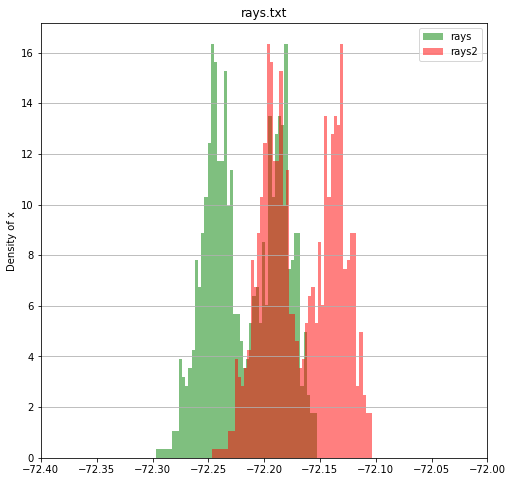

In [21]:
rays2 = deepcopy(rays)
rays2.x = rays.x+0.05 # nudge to the right a little

#plot two hists on same ax
fig, ax = plt.subplots(figsize=(8,8))
rays.MyHistogram(ax=ax,bins=50, density=True, xlim=(-72.4,-72), color='green', alpha=0.5, label='rays')
rays2.MyHistogram(ax=ax,bins=50, density=True, xlim=(-72.4,-72), color='red', alpha=0.5, label='rays2')
ax.grid(axis='y')
ax.legend()
